In [1]:
import numpy as np
import pandas as pd
import os
import re
import pyedflib

from scipy.signal import butter, lfilter
from pyentrp import entropy as ent
from scipy.signal import stft
from scipy.signal import welch
from scipy.signal import boxcar
from scipy.stats import variation
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import describe

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generateEEGdataDF(file, seg_length):
#this function loads the data files, and parses the data into an appropriate dataframe
    
    #open the file, catch exception if file is already open
    try:
        f = pyedflib.EdfReader(file)
    except OSError:
        print('File already open')
        f._close()
    
    #load relevent parameters into df
    numChannels = f.signals_in_file
    channelName=[]
    channelSamples=[]
    Fs=[]
    traces=[]
    for channel in range(numChannels):
        channelName.append(f.getLabel(channel))
        channelSamples.append(f.getNSamples()[channel])
        Fs.append(f.getSampleFrequency(channel))
        traces.append(f.readSignal(channel))
    
    EEGdata=pd.DataFrame([channelName,channelSamples,Fs,traces],index=['channelName','channelSamples','Fs','traces'])
    
    #get engineered features from loaded data, add to existing df
    segmentedTimeDomainFeatures(EEGdata,seg_length)
    #remember to close the file!
    f._close()
    
    return EEGdata.transpose()

In [5]:
def segmentedTimeDomainFeatures(EEGdata,seg_length):
#this function calculates spectral features as well as time-series features along the segment 
#length specified (seg_length)    
    for i in EEGdata.columns:
        
        samples_per_segment = EEGdata.loc['channelSamples'][i]/(EEGdata.loc['Fs'][i]/seg_length)
        tot_segments = np.floor(EEGdata.loc['channelSamples'][i]/samples_per_segment).astype(np.int)
        
        #calculate the start and end times of each segment
        startSamples = [np.int(x) for x in range(tot_segments)*samples_per_segment]
        endSamples = [np.int(x) for x in startSamples + samples_per_segment]
        
        
        #generate features for each segment
        
        mean_data=[]
        std_data=[]
        rms_data=[]
        kurtosis_data=[]
        cov_data=[]
        skew_data=[]
        
        
        #data = nolds.corr_dim(EEGdata.loc['traces'][i][st:en], 1)
        for st,en in zip(startSamples,endSamples):
            
            mean_data.append(np.mean(np.absolute(EEGdata.loc['traces'][i][st:en])))            
            std_data.append(np.std(np.absolute(EEGdata.loc['traces'][i][st:en])))
            kurtosis_data.append(kurtosis(np.absolute(EEGdata.loc['traces'][i][st:en])))
            cov_data.append(variation(np.absolute(EEGdata.loc['traces'][i][st:en])))
            skew_data.append(skew(np.absolute(EEGdata.loc['traces'][i][st:en])))
            rms_data.append(np.sqrt(np.mean((np.absolute(EEGdata.loc['traces'][i][st:en]))**2)))
        
        
        EEGdata.at['mean',i]=mean_data
        EEGdata.at['std',i]=std_data
        EEGdata.at['rms',i]=rms_data
        EEGdata.at['kurtosis',i]=kurtosis_data
        EEGdata.at['cov',i]=cov_data
        EEGdata.at['skewness',i]=skew_data
        
    print('samples_per_segment: {}\nTotal Segment: {}'.format(samples_per_segment,tot_segments))
        

In [6]:
#the .edf files contain exactly one hour of digitized EEG signals, although those belonging to case chb10 are two hours 
#long, and those belonging to cases chb04, chb06, chb07(case-13: 1Hour), chb09(case-19:2Hour)
# and chb23 are four hours long

#select data directory
dataDir='/home/mirwais/chbmit/chb01'

#create listings of recordings that contain seizures
fileListing=os.listdir(dataDir)
seizureFiles = [x for x in fileListing if 'seizure' in x and '.edf' in x]
normalFiles = [x for x in fileListing if 'seizure' not in x and '.edf' in x]
seizureRecordIDs = [np.int(re.search('(?<=_)(.*?)(?=.edf)',s).group(0).lstrip("0")) for s in seizureFiles]
normalPaths = [os.path.join(dataDir,s) for s in normalFiles]

#aggregate data into df
studyDataList=[]
studyKeyList = []
for idx,files in enumerate(normalPaths):
    #For 1Hour long file: (16/225) => 1 sec,
    #For 2Hours long file: (16/450) => 1 sec,
    #For 4Hours long files: (16/900) => 1 sec
    studyDataList.append(generateEEGdataDF(files,(32/225)))
    studyKeyList.append(np.int(re.search('(?<=_)(.*?)(?=.edf)',normalFiles[idx]).group(0).lstrip("0")))
    
studyDF = pd.concat(studyDataList,axis=0,keys=studyKeyList, names=['recordingID', 'electrode'])
studyDF=studyDF[studyDF.channelName != '-']
studyDF.sort_index(axis=0,level=0,inplace=True,sort_remaining=False)

#label targets
studyDF['sz'] = 0
#for j in seizureRecordIDs:
 #   for idx,st in enumerate(studyDF.index.get_level_values(level=0)):
  #      if(st==j):
   #         studyDF.iloc[idx,-1] = 1
    

#list of derived features to be analyzed
derivedFeatures = studyDF.loc[:,['mean','std','rms','kurtosis','cov','skewness']]

       
#unstack lists into new series


f4 = derivedFeatures.apply(lambda x: pd.Series(x['mean']),axis=1).stack().reset_index(level=1, drop=True)
f4.name = 'mean'

f7 = derivedFeatures.apply(lambda x: pd.Series(x['std']),axis=1).stack().reset_index(level=1, drop=True)
f7.name = 'std'

f8 = derivedFeatures.apply(lambda x: pd.Series(x['rms']),axis=1).stack().reset_index(level=1, drop=True)
f8.name='rms'

f9 = derivedFeatures.apply(lambda x: pd.Series(x['kurtosis']),axis=1).stack().reset_index(level=1, drop=True)
f9.name = 'kurtosis'

f10 = derivedFeatures.apply(lambda x: pd.Series(x['cov']),axis=1).stack().reset_index(level=1, drop=True)
f10.name = 'cov'

f11 = derivedFeatures.apply(lambda x: pd.Series(x['skewness']),axis=1).stack().reset_index(level=1, drop=True)
f11.name = 'skewness'

#concatenate unstacked features
featuresUnstack = pd.concat([f4,f7,f8,f9,f10,f11],axis=1)

#apply targets to reshaped/flattened df
featuresUnstack['sz'] = 0
#for j in seizureRecordIDs:
 #   for idx,st in enumerate(featuresUnstack.index.get_level_values(level=0)):
  #      if (st == j):
   #         featuresUnstack.iloc[idx,-1] = 1

samples_per_segment: 330.6666666666667
Total Segment: 1800
samples_per_segment: 512.0
Total Segment: 1800
samples_per_segment: 512.0
Total Segment: 1800
samples_per_segment: 512.0
Total Segment: 1800
samples_per_segment: 512.0
Total Segment: 1800
samples_per_segment: 512.0
Total Segment: 1800
samples_per_segment: 512.0
Total Segment: 1800


In [7]:
featuresUnstack.head()

mean        std        rms  kurtosis       cov  skewness  \
recordingID                                                                    
3           0  20.550214  17.696418  27.119633  2.066814  0.861131  1.468444   
            1  25.249542  16.868504  30.365866 -0.198460  0.668072  0.511631   
            2  19.120116  14.680455  24.105904  1.608054  0.767802  1.097547   
            3  17.452686  12.166339  21.274775 -0.368353  0.697104  0.668310   
            4  24.368895  18.409445  30.540968  0.616122  0.755448  0.983190   

               sz  
recordingID        
3           0   0  
            1   0  
            2   0  
            3   0  
            4   0

### 4. Storing data in csv file

In [8]:
csvFilePath = '/home/mirwais/notebooks/paper_2/data/chb01_time_segments.csv'

In [9]:
featuresUnstack.to_csv(csvFilePath)

In [10]:
ch = pd.read_csv(csvFilePath)
ch.rename(columns={'Unnamed: 1': 'time'}, inplace=True)

In [11]:
ch.head()

,recordingID,time,mean,std,rms,kurtosis,cov,skewness,sz
0,3,0,20.550214,17.696418,27.119633,2.066814,0.861131,1.468444,0
1,3,1,25.249542,16.868504,30.365866,-0.198460,0.668072,0.511631,0
2,3,2,19.120116,14.680455,24.105904,1.608054,0.767802,1.097547,0
3,3,3,17.452686,12.166339,21.274775,-0.368353,0.697104,0.668310,0
4,3,4,24.368895,18.409445,30.540968,0.616122,0.755448,0.983190,0


### 5. Labeling data to three states (Normal vs pre-Seziure vs Seizure)

In [19]:
import re
import numpy as np

def extract_data_and_labels(edf_filename, summary_text):
    folder, basename = os.path.split(edf_filename)
    
    i_text_start = summary_text.index(basename)
    
    if 'File Name' in summary_text[i_text_start:]:
        i_text_stop = summary_text.index('File Name', i_text_start)
    else:
        i_text_stop = len(summary_text)
    assert i_text_stop > i_text_start

    file_text = summary_text[i_text_start:i_text_stop]
    if 'Seizure Start' in file_text:
        start_sec = int(int(re.search(r"Seizure Start Time: ([0-9]*) seconds", file_text).group(1))/2)
        pre_start_sec = start_sec - 40
        end_sec = int(int(re.search(r"Seizure End Time: ([0-9]*) seconds", file_text).group(1))/2)
        end_sec_post = end_sec + 0
        print('Seizure {}:{}\tPreSeizure {}:{} => {}'.format(start_sec, end_sec,pre_start_sec,end_sec_post, int(basename[6:8])))
        
        #ch.loc[start_sec:end_sec,'sz']  = ((ch.time >= start_sec) & (ch.time <= end_sec) & (ch.recordingID == int(basename[6:8])))
        ch.loc[((ch.time >= start_sec) & (ch.time <= end_sec) & (ch.recordingID == int(basename[6:8]))), 'sz'] = 2
        ch.loc[((ch.time >= pre_start_sec) & (ch.time < start_sec) & (ch.recordingID == int(basename[6:8]))), 'sz'] = 1
        ch.loc[((ch.time > end_sec) & (ch.time <= end_sec_post) & (ch.recordingID == int(basename[6:8]))), 'sz'] = 1
        #print(ch.loc[start_sec-1:end_sec+1,'sz'])

In [20]:
import glob
import os.path
try:
    file_numbers = [1]
    for i in file_numbers:
    
        subject_id = 1
        base_path = "/home/mirwais/chbmit/"
        edf_file_names = sorted(glob.glob(os.path.join(base_path, "chb{:02d}/*.edf".format(subject_id))))
        summary_file = os.path.join(base_path, "chb{:02d}/chb{:02d}-{}summary.txt".format(subject_id, subject_id, i))

        summary_content = open(summary_file,'r').read()
        for edf_file_name in edf_file_names:
            result = extract_data_and_labels(edf_file_name, summary_content)
            print(result)
        print('\n.....................................................')
            
except Exception:
    pass

Seizure 1498:1518	PreSeizure 1458:1518 => 3
None
Seizure 733:747	PreSeizure 693:747 => 4
None
Seizure 866:886	PreSeizure 826:886 => 15
None
Seizure 507:533	PreSeizure 467:533 => 16
None
Seizure 860:905	PreSeizure 820:905 => 18
None
Seizure 163:210	PreSeizure 123:210 => 21
None
Seizure 931:981	PreSeizure 891:981 => 26
None

.....................................................


In [23]:
ch[(ch.sz==2) & (ch.recordingID == 26)]

,recordingID,time,1st_qu,median,mean,3rd_qu,max,std,rms,kurtosis,cov,skewness,sz
249331,26,931,7.228327,14.261294,15.698672,22.857143,41.611722,10.522622,18.899044,-0.719169,0.670287,0.478686,2
249332,26,932,8.009768,14.261294,16.446960,22.466422,50.598291,11.615988,20.135384,0.037822,0.706270,0.823705,2
249333,26,933,6.935287,15.433455,16.428016,24.029304,43.565324,10.856758,19.691341,-0.789628,0.660868,0.392841,2
249334,26,934,10.354090,23.247863,26.355866,37.313797,83.418803,18.978283,32.477791,-0.073782,0.720078,0.769061,2
249335,26,935,5.763126,14.065934,18.016946,24.420024,77.557998,15.803199,23.965630,1.863081,0.877130,1.396827,2
249336,26,936,14.652015,25.982906,28.218300,39.267399,88.498168,18.300270,33.632906,0.592077,0.648525,0.807785,2
249337,26,937,9.181929,17.191697,23.709624,33.406593,86.153846,19.623665,30.777175,0.799994,0.827667,1.152300,2
249338,26,938,6.544567,16.214896,22.905687,29.010989,129.133089,25.647957,34.387326,6.236042,1.119720,2.453661,2
249339,26,939,7.619048,13.089133,15.532912,21.684982,52.551893,11.286970,19.200704,1.091031,0.726649,1.086256,2
249340,26,940,6.544567,11.916972,13.478669,18.559219,37.704518,8.591838,15.984186,-0.270981,0.637440,0.628737,2


In [24]:
# Saving data as pre_seizure 40sec
lebaledCSVFilePath = '/home/mirwais/notebooks/paper_2/data/lebaled/40_0sec_chb01_time_segments.csv'
ch.to_csv(lebaledCSVFilePath)

In [25]:
ch = pd.read_csv(lebaledCSVFilePath)
ch.columns.size

14

In [26]:
ch.head()

,Unnamed: 0,recordingID,time,1st_qu,median,mean,3rd_qu,max,std,rms,kurtosis,cov,skewness,sz
0,0,3,0,8.009768,15.824176,20.550214,27.545788,88.107448,17.696418,27.119633,2.066814,0.861131,1.468444,0
1,1,3,1,10.744811,24.029304,25.249542,38.095238,86.935287,16.868504,30.365866,-0.198460,0.668072,0.511631,0
2,2,3,2,7.228327,17.387057,19.120116,27.545788,81.855922,14.680455,24.105904,1.608054,0.767802,1.097547,0
3,3,3,3,7.228327,15.238095,17.452686,25.592186,52.161172,12.166339,21.274775,-0.368353,0.697104,0.668310,0
4,4,3,4,10.354090,19.731380,24.368895,34.578755,92.014652,18.409445,30.540968,0.616122,0.755448,0.983190,0


In [27]:
import numpy as np
import pandas as pd
import random
import csv

import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score, \
                                    cross_validate, GridSearchCV

from sklearn.metrics import make_scorer
from imblearn.metrics import specificity_score, classification_report_imbalanced, \
                                sensitivity_specificity_support, sensitivity_score, \
                                geometric_mean_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
            classification_report, recall_score, precision_recall_curve, roc_auc_score, \
            precision_score, accuracy_score

from sklearn.neighbors import KNeighborsClassifier

# Define random state
random_state = 2018
np.random.seed(random_state)

<Figure size 432x288 with 0 Axes>

In [30]:
lebaledCSVFilePath = '/home/mirwais/notebooks/paper_2/data/lebaled/40_0sec_chb01_time_segments.csv'
df = pd.read_csv(lebaledCSVFilePath)
df.columns.size

14

In [31]:
df["sz"].value_counts()

0    278093
1      6440
2      5267
Name: sz, dtype: int64

In [39]:
# With F1 Score
x = df.drop(['sz','recordingID','Unnamed: 0','time'], axis=1)
#x = featuresUnstack.drop(['sz'], axis=1)
y = df['sz']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=random_state)

#dissimilar scales of data, StandardScaler should be used
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = random_state)

clf = KNeighborsClassifier(metric='minkowski', p=2)

params = {'n_neighbors': list(range(1,10))
         } 

grid_sclf = GridSearchCV(estimator = clf, param_grid = params, cv = cv, n_jobs=-1, scoring='f1_macro', verbose=4)
grid_sclf.fit(x_train_std, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] ......... n_neighbors=1, score=0.45374131303064885, total=   1.2s
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.4351924735349284, total=   1.2s
[CV] n_neighbors=1 ...................................................
[CV] .......... n_neighbors=1, score=0.4447744403198475, total=   1.2s
[CV] n_neighbors

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s


[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.3816481910406914, total=   1.5s
[CV] n_neighbors=2 ...................................................
[CV] ......... n_neighbors=2, score=0.37208266285175723, total=   1.5s
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.3790519030405457, total=   1.5s
[CV] ............ n_neighbors=2, score=0.37090556786358, total=   1.6s
[CV] n_neighbors=3 ...................................................
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=2, score=0.3866535353840958, total=   1.5s
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=2, score=0.3911334349644951, total=   1.6s
[CV] n_neighbors=3 ...................................................
[CV] ........... n_neighbors=2, score=0.389038804294867, total=   1.4s
[CV] n

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .......... n_neighbors=5, score=0.4045259594688589, total=   1.9s
[CV] n_neighbors=6 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=6, score=0.35975702927570546, total=   2.2s
[CV] n_neighbors=6 ...................................................
[CV] ......... n_neighbors=6, score=0.39055848446443125, total=   2.7s
[CV] n_neighbors=6 ...................................................
[CV] ......... n_neighbors=6, score=0.37032600785467246, total=   1.9s
[CV] n_neighbors=7 ...................................................
[CV] .......... n_neighbors=6, score=0.3838719101461227, total=   2.2s
[CV] n_neighbors=7 ...................................................
[CV] .......... n_neighbors=6, score=0.3876851812539876, total=   2.2s
[CV] n_neighbors=7 ...................................................
[CV] .......... n_neighbors=6, score=0.3751353758664573, total=   2.2s
[CV] n_neighbors=7 ...................................................
[CV] ......... n_neighbors=6, score=0.39502242926155967, total=   2.0s
[CV] n_neighbors=7 ...................................................
[CV] .

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=6, score=0.37412536443836736, total=   2.2s
[CV] n_neighbors=7 ...................................................
[CV] ......... n_neighbors=6, score=0.37895603773451375, total=   1.9s
[CV] n_neighbors=7 ...................................................
[CV] ......... n_neighbors=7, score=0.40090570847839313, total=   2.0s
[CV] n_neighbors=7 ...................................................
[CV] ........... n_neighbors=7, score=0.377093639737859, total=   2.2s
[CV] n_neighbors=7 ...................................................
[CV] ......... n_neighbors=7, score=0.38921937801423434, total=   2.2s
[CV] n_neighbors=8 ...................................................
[CV] .......... n_neighbors=7, score=0.4040540036064342, total=   2.1s
[CV] n_neighbors=8 ...................................................
[CV] .......... n_neighbors=7, score=0.3943555353305637, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=7, score=0.40967387780031256, total=   2.0s
[CV] n_neighbors=8 ...................................................
[CV] .......... n_neighbors=7, score=0.3897627312356615, total=   2.3s
[CV] n_neighbors=8 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .......... n_neighbors=7, score=0.3912104975470636, total=   2.0s
[CV] n_neighbors=8 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=7, score=0.39845269893680774, total=   2.2s
[CV] n_neighbors=8 ...................................................
[CV] ......... n_neighbors=8, score=0.36753975092320884, total=   2.2s
[CV] n_neighbors=8 ...................................................
[CV] ......... n_neighbors=8, score=0.39572998228424056, total=   2.3s
[CV] n_neighbors=8 ...................................................
[CV] .......... n_neighbors=8, score=0.3728760541876614, total=   2.1s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .......... n_neighbors=8, score=0.3880234582193291, total=   2.1s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=8, score=0.38384447458349685, total=   2.1s
[CV] n_neighbors=9 ...................................................
[CV] ......... n_neighbors=8, score=0.38394941285347756, total=   2.1s
[CV] n_neighbors=9 ...................................................
[CV] .......... n_neighbors=8, score=0.3868610658353822, total=   2.0s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .......... n_neighbors=8, score=0.3782131129672342, total=   3.3s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=8, score=0.38244816565040307, total=   2.3s
[CV] n_neighbors=9 ...................................................
[CV] .......... n_neighbors=8, score=0.3720958805015604, total=   2.4s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=9, score=0.40850435286834824, total=   2.7s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=9, score=0.37605588879584456, total=   2.4s
[CV] n_neighbors=9 ...................................................


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......... n_neighbors=9, score=0.38652464528589464, total=   2.3s
[CV] .......... n_neighbors=9, score=0.3988202183733453, total=   2.2s
[CV] .......... n_neighbors=9, score=0.4007828586229703, total=   2.1s
[CV] .......... n_neighbors=9, score=0.3888884952508486, total=   2.5s
[CV] .......... n_neighbors=9, score=0.4092299186105923, total=   2.4s
[CV] ......... n_neighbors=9, score=0.38622778246701017, total=   2.2s
[CV] ......... n_neighbors=9, score=0.37910749945892913, total=   2.2s
[CV] ......... n_neighbors=9, score=0.39691149629068434, total=   2.2s


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2018, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=4)

In [40]:
print(grid_sclf.best_estimator_)
print(grid_sclf.best_params_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
{'n_neighbors': 1}


Accuracy of Decision Tree Model: 93.52%


                   pre       rec       spe        f1       geo       iba       sup

     Normal     0.9665    0.9665    0.2110    0.9665    0.4516    0.2194     83395
Pre-seizure     0.1385    0.1358    0.9805    0.1371    0.3685    0.1244      1959
    Seizure     0.2697    0.2762    0.9861    0.2729    0.5158    0.2470      1586

avg / total     0.9351    0.9352    0.2425    0.9351    0.4509    0.2178     86940



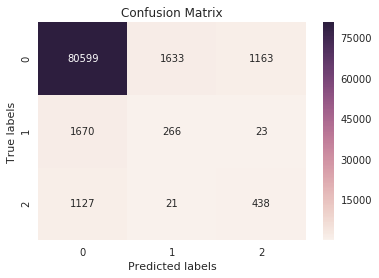

In [41]:
#Prediction
y_predict = grid_sclf.predict(x_test_std)

print('Accuracy of Decision Tree Model: %0.2f%%\n\n' % (accuracy_score(y_test,y_predict)*100))

#generate and plot confusion matrix
dsvm_cm = confusion_matrix(y_test,y_predict)

ax= sns.heatmap(dsvm_cm, annot=True, fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

#Classification Report 
target_names = ['Normal', 'Pre-seizure', 'Seizure']

#print(classification_report(y_test, y_predict, digits=4, target_names=target_names))
print(classification_report_imbalanced(y_test, y_predict, target_names=target_names, digits=4))